In [19]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy.ndimage
from scipy import fftpack
from scipy import *

In [39]:
def azimuthalAverage(image, center = None, edges = None, logbins = False, bins = 50, return_num_modes=0):
    """
    Calculate the azimuthally averaged radial profile.
    Input:
    image = The 2D image
    center = The [x,y] pixel coordinates used as the center. The default is None, which then uses the center of the image (including fracitonal pixels).
    Output:
    ell_arr = the ell's, lower edge
    tbin = power spectrum
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])
    
    ## added below on oct/31/2014, 
    ## since nyquist freqnecy is not centered for even # mapsize

    if image.shape[0]%2 == 0:
        center+=0.5
    
    r = np.hypot(x - center[0], y - center[1])#distance to center pixel, for each pixel

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind] # the index to sort by r
    i_sorted = image.flat[ind] # the index of the images sorted by r

    # find index that's corresponding to the lower edge of each bin
    kmin=1.0
    kmax=image.shape[0]/2.0
    if edges == None:
        if logbins:
            edges = np.logspace(np.log10(kmin),np.log10(kmax),bins+1)
        else:
            #edges = linspace(kmin,kmax+0.001,bins+1)    
            edges = np.linspace(kmin,kmax,bins+1)
    if edges[0] > 0:
        edges = np.append([0],edges)
        
    hist_ind = np.histogram(r_sorted,bins = edges)[0] # hist_ind: the number in each ell bins, sum them up is the index of lower edge of each bin, first bin spans from 0 to left of first bin edge.    
    hist_sum = np.cumsum(hist_ind)
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[hist_sum[1:]] - csim[hist_sum[:-1]]
    radial_prof = tbin/hist_ind[1:]
    if return_num_modes:
        #where N=hist_sum[1:]-hist_sum[:-1] is the number of modes in each bin, but note N/2 is the num of independent modes
        return edges[1:], radial_prof, (hist_sum[1:]-hist_sum[:-1])/2.0
    else:
        return edges[1:], radial_prof

In [40]:
edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])

In [41]:
def PowerSpectrum(img, sizedeg = 12.25, edges = None, logbins = True, sigmaG=0, bins=50):#edges should be pixels
    '''Calculate the power spectrum for a square image, with normalization.
    Input:
    img = input square image in numpy array.
    sizedeg = image real size in deg^2
    edges = ell bin edges, length = nbin + 1, if not provided, then do 1000 bins.
    sigmaG = smoothing scale in arcmin
    Output:
    powspec = the power at the bins
    ell_arr = lower bound of the binedges
    '''
    img = img.astype(float)
    size = img.shape[0]
    #F = fftpack.fftshift(fftpack.fft2(img))
    F = fftpack.fftshift(fftpack.fft2(img))
    psd2D = np.abs(F)**2
    ## correct for b_ell
    #psd2D /= bell_2D(size, sigmaG*PPA512)**2
    ell_arr, psd1D = azimuthalAverage(psd2D, center=None, edges = edges,logbins = logbins, bins=bins)
    ell_arr = edge2center(ell_arr)
    ell_arr *= 360./np.sqrt(sizedeg)# normalized to our current map size
    norm = ((2*np.pi*np.sqrt(sizedeg)/360.0)**2)/(size**2)**2
    powspec = ell_arr*(ell_arr+1)/(2*np.pi) * norm * psd1D
    return ell_arr, powspec

C:\Users\rehg98\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


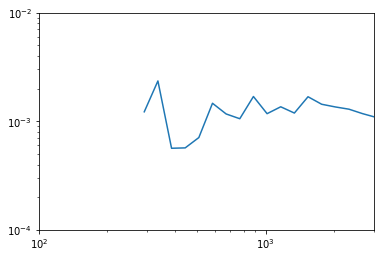

In [42]:
image_file = fits.open('file:///C:/cygwin64/home/rehg98/WLconv_z1100.00_0580r.fits')
image_data = image_file[0].data
smooth_data = scipy.ndimage.filters.gaussian_filter(image_data, 9.75)
psd1D = PowerSpectrum(smooth_data)
plt.loglog(psd1D[0], psd1D[1])
plt.xlim(100, 3000)
plt.ylim(1e-4, 1e-2)

plt.show()